# Linear regression comparison of tools

In [1]:
import pandas as pd
from pathlib import Path # type: ignore
from freyja_plot import FreyjaPlotter
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
if (module_path:=str(Path(".").absolute().resolve().parent)) not in sys.path:
    sys.path.insert(0, module_path)
from sample_info import renameSamples, summary_dict, expected, varskip_runs as runs

## Collect lineage/abundance info for all samples for all tools

In [2]:
file_map = {expected:"Expected"}
for tool, files in runs.items():
    for name,file in files.items():
        if "WB" == name:
            file_map[file] = tool
plotter = FreyjaPlotter(
    file_map=file_map,
    # colormap=colormap,
    summary_dict=summary_dict,
)
plotter = renameSamples(plotter)
df = plotter.summarized_freyja_df.rename(columns={"Sample name":"sample","abundances":"abundance","scheme":"tool","lineages":"lineage"})
df

,sample,lineage,abundance,tool
666,0,BA.5.X,0.0088,kallisto
669,0,Lambda,0.0064,kallisto
1507,0,Beta,0.0050,kallisto (C-WAP)
1506,0,BA.4.X,0.0060,kallisto (C-WAP)
1505,0,BA.1.X,0.0060,kallisto (C-WAP)
...,...,...,...,...
1007,o5-3,Eta,0.0021,kallisto
1006,o5-3,Alpha,0.0025,kallisto
1005,o5-3,Epsilon,0.0026,kallisto
1739,o5-3,BA.2.X,0.0290,kallisto (C-WAP)


## Gather L2 median results in an array

In [3]:
lineages = set(df["lineage"].unique())
l2_tools = set(runs.keys())
l2s = []

# for each sample, calculate l2 array for the tools
for sample in set(df["sample"].unique()) - {None}:
    sample_df = df.loc[df['sample'] == sample, ('tool', 'lineage', 'abundance')]
    
    pivoted_sample_df = sample_df.pivot_table(index='lineage', columns='tool', values='abundance').fillna(0).T

    # for any missing tool, append 0-abundance df to bottom
    dfs2append = []
    missing_tools = l2_tools - set(pivoted_sample_df.index.unique())
    for tool in missing_tools:
        dfs2append.append(
            pd.DataFrame({lin:[0] for lin in lineages},index=[tool])
        )
    if dfs2append:
        pivoted_sample_df = pd.concat([pivoted_sample_df]+dfs2append).fillna(0)
    pivoted_sample_df = pivoted_sample_df.reindex(["Expected"] + [x for x in pivoted_sample_df.index if x != "Expected"])

    Y = squareform(pdist(pivoted_sample_df, 'euclidean'))
    l2s.append(Y)

# get order of tools, as they appear in the l2s
l2_index = pivoted_sample_df.index

# combine l2 results into a single condenced array
l2s_stacked = np.stack(l2s)
l2m = np.median(l2s_stacked, axis=0)
l2m

array([[0.        , 0.06906307, 0.03138031, 1.04488532, 0.17167085,
        0.35694468, 0.10942324, 0.31684009, 0.28494647, 1.14554592],
       [0.06906307, 0.        , 0.05346641, 1.00147613, 0.08554811,
        0.22344088, 0.07638611, 0.31666566, 0.19227426, 1.10853603],
       [0.03138031, 0.05346641, 0.        , 0.93105816, 0.17407882,
        0.31289764, 0.09033967, 0.32980962, 0.29811199, 1.15392233],
       [1.04488532, 1.00147613, 0.93105816, 0.        , 0.91652366,
        0.45756581, 0.81448035, 0.71083191, 0.73691772, 1.07275588],
       [0.17167085, 0.08554811, 0.17407882, 0.91652366, 0.        ,
        0.2681427 , 0.12319002, 0.31525007, 0.23695229, 1.0764156 ],
       [0.35694468, 0.22344088, 0.31289764, 0.45756581, 0.2681427 ,
        0.        , 0.35041623, 0.28929315, 0.22760437, 1.02081238],
       [0.10942324, 0.07638611, 0.09033967, 0.81448035, 0.12319002,
        0.35041623, 0.        , 0.30975731, 0.28877233, 1.09229846],
       [0.31684009, 0.31666566, 0.3298096

## Reorder array: lowest to highest (best to worst)

In [4]:
expected_vs_tools = list(l2m[0])
if len(set(expected_vs_tools)) < len(expected_vs_tools):
    raise Exception("Can't sort things when any values are duplicated")
idx = [expected_vs_tools.index(x) for x in sorted(expected_vs_tools)]
l2m_clustered = l2m[idx,:]
l2m_clustered = l2m_clustered[:,idx]
l2m_clustered

array([[0.        , 0.03138031, 0.06906307, 0.10942324, 0.17167085,
        0.28494647, 0.31684009, 0.35694468, 1.04488532, 1.14554592],
       [0.03138031, 0.        , 0.05346641, 0.09033967, 0.17407882,
        0.29811199, 0.32980962, 0.31289764, 0.93105816, 1.15392233],
       [0.06906307, 0.05346641, 0.        , 0.07638611, 0.08554811,
        0.19227426, 0.31666566, 0.22344088, 1.00147613, 1.10853603],
       [0.10942324, 0.09033967, 0.07638611, 0.        , 0.12319002,
        0.28877233, 0.30975731, 0.35041623, 0.81448035, 1.09229846],
       [0.17167085, 0.17407882, 0.08554811, 0.12319002, 0.        ,
        0.23695229, 0.31525007, 0.2681427 , 0.91652366, 1.0764156 ],
       [0.28494647, 0.29811199, 0.19227426, 0.28877233, 0.23695229,
        0.        , 0.3179826 , 0.22760437, 0.73691772, 1.10261405],
       [0.31684009, 0.32980962, 0.31666566, 0.30975731, 0.31525007,
        0.3179826 , 0.        , 0.28929315, 0.71083191, 0.89669042],
       [0.35694468, 0.31289764, 0.2234408

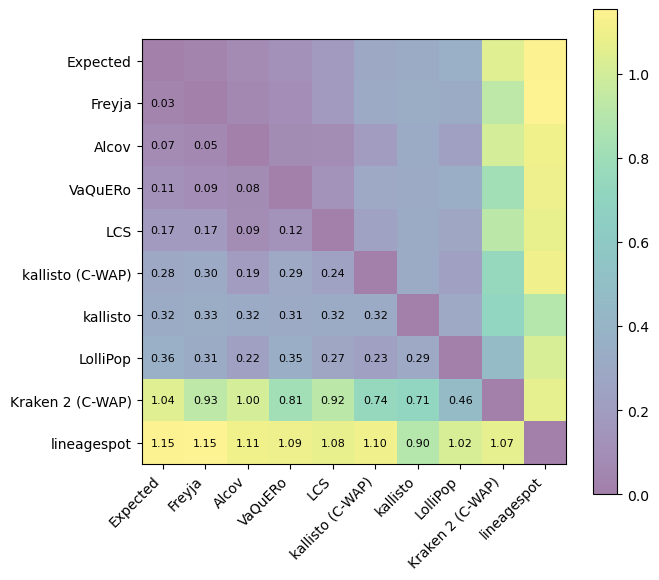

In [5]:
# plot
fig, (ax) = plt.subplots(1, 1, figsize=(6.85, 9))

N = len(l2_index)

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

for (j,i), label in np.ndenumerate(l2m_clustered):
    if j > i:
        ax.text(i, j,'{:.2f}'.format(label), ha='center', va='center', fontsize=8)

cmap = matplotlib.colormaps.get_cmap('viridis') # jet doesn't have white color
cmap.set_bad('w') # default value is 'k'

im = ax.imshow(l2m_clustered, alpha=0.5, cmap=cmap, aspect='equal')
fig.colorbar(im, ax=ax, shrink=0.7)

ax.set_xticks(np.arange(N))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(l2_index[idx], rotation=45, ha='right')
ax.set_yticklabels(l2_index[idx])

# fig.savefig('Fig2_L2_matrix.tiff', bbox_inches='tight')
fig.savefig('Fig2_L2_matrix.png', bbox_inches='tight')